In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [36]:
FIRM = 'IDFC First Bank'
PRIVATE_DEFAULT_COLOR = 'lightgrey'
PUBLIC_DEFAULT_COLOR = 'grey'
HIGHLIGHT = 'orange'
N = 5
MOST_RECENT_COL_NAME = 'Mar 22'

#### Aggregator

In [37]:
drive_path = '/Users/Oruganti/Library/CloudStorage/GoogleDrive-finmetrics0@gmail.com/My Drive'
root = f'{drive_path}/Fin Labs/data/supplement data/money_control/financials'
stat_folder = f'{root}/10-2022'

In [38]:
tickers = pd.read_csv(f'{root}/mc_tickers.csv')
tickers = tickers[tickers['industry_group'].str.contains('Bank')]
tickers = tickers[~tickers['industry_sub_group'].str.contains('Other Bank')]
companies = [f'{c}.xlsx' for c in tickers['security_name']]
len(companies)

31

In [39]:
def extract_info(sheet_name, attributes, n):
    missing = []
    dfs = []
    for c in companies:
        xl = pd.ExcelFile(f'{stat_folder}/{c}')
        if sheet_name[0] in xl.sheet_names:
            sheet = sheet_name[0]
        elif sheet_name[1] in xl.sheet_names:
            sheet = sheet_name[1]
        else:
            sheet = ''
        
        if sheet != '':
            try:
                df = pd.read_excel(f'{stat_folder}/{c}', sheet_name = sheet, index_col = 0)
                df = df.loc[attributes, df.columns[:n]]
                if df.empty:
                    missing.append(c)
                else:
                    df.reset_index(inplace = True)
                    df.rename(columns = {df.columns[0] : 'index'}, inplace = True)
                    df.index = [c] * df.shape[0]
                    dfs.append(df)
            except:
                missing.append(c)
                
    df = pd.concat(dfs)
    
    return missing, df

In [40]:
### SUPPORTING FUNCTIONS
def append_group(df):
    df = df.copy(deep = True)
    group_df = tickers[['security_name', 'industry_sub_group']].rename(columns = {'security_name' : 'name', 'industry_sub_group' : 'group'})
    group_df['group'] = group_df['group'].apply(lambda x: x.split()[0].lower())
    df = df.merge(group_df, on = 'name')
    return df

#### Intensity of borrowing
Customer deposits are cheapest borrowing vehicle for the banks, however they borrow from other banks at a higher
rate to meet the growth demand. The fraction of borrowing on deposits is a measurement is a relative measure provided 
the deposits are significant enough

In [41]:
### PULL DATA
sheet_name = ['consolidated-balance-sheet', 'balance-sheet']
attributes = ['Deposits', 'Borrowings', 'Other Liabilities and Provisions']
missing, df = extract_info(sheet_name, attributes, N)
print(f'missing: {len(missing)}')
df['aggregate'] = df.sum(axis= 1)
df['recent'] = df[MOST_RECENT_COL_NAME]
df.reset_index(inplace = True)
df.rename(columns = {'level_0' : 'name'}, inplace = True)
df['name'] = df['name'].str.replace('.xlsx', '')
print(df.shape)

### COMPUTE
borrow_deposit_ratio = []
for name in df['name'].unique():
    deposits = df[(df['name'] == name) & (df['index'] == 'Deposits')]['aggregate'].values[0]
    borrowings = df[(df['name'] == name) & (df['index'] == 'Borrowings')]['aggregate'].values[0]
    
    ratio = borrowings / (deposits + borrowings)
    
    # mean in lakhs of crores 
    deposits = df[(df['name'] == name) & (df['index'] == 'Deposits')]['recent'].values[0] / 1e5
    borrowings = df[(df['name'] == name) & (df['index'] == 'Borrowings')]['recent'].values[0] / 1e5
    
    borrow_deposit_ratio.append((name, deposits, borrowings, ratio))
df = pd.DataFrame(borrow_deposit_ratio, columns = ['name', 'deposits', 'borrowings', 'agg_pct_borrowing'])
# append group
df = append_group(df)

missing: 0
(93, 9)


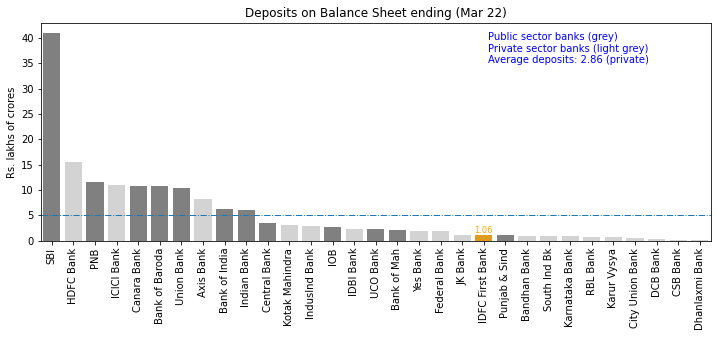

In [42]:
### DEPOSITS
df.sort_values(by = 'deposits', ascending = False, inplace = True)
df.reset_index(drop = True, inplace = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = 'deposits', palette = clrs)
plt.xticks(rotation = 90)
plt.axhline(y = 5, ls = '-.', lw = 1)
plt.title(f'Deposits on Balance Sheet ending ({MOST_RECENT_COL_NAME})')
plt.ylabel('Rs. lakhs of crores')
plt.xlabel('')

# add text annotation
avg = df[df['group'] == 'private']['deposits'].mean()
annotation = f'''Public sector banks (grey)
Private sector banks (light grey)
Average deposits: {avg:.2f} (private)'''
plt.text(20+0.2, 35, annotation, horizontalalignment='left', size='medium', color='blue')

# show the company's value
index, value = df[df['name'] == FIRM].index.values[0], df[df['name'] == FIRM]['deposits'].values[0]
plt.text(index, value + 0.5, f'{value:.2f}', 
         horizontalalignment='center', size='small', color='orange')

plt.show()

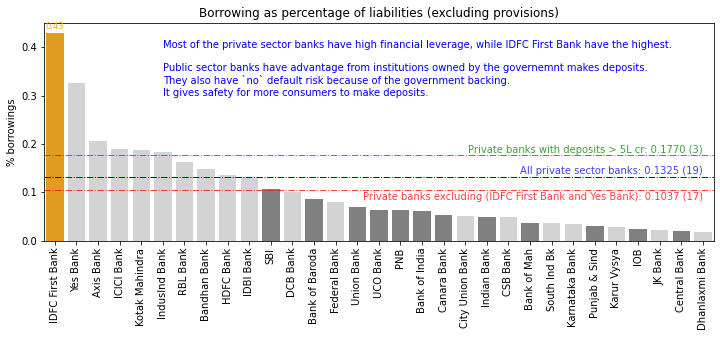

In [43]:
### BORROWING AS PCT OF LIABILITIES (EXCLUDING PROVISIONS)
plt.figure(figsize = (12, 4))
df.sort_values(by = 'agg_pct_borrowing', ascending = False, inplace = True)
df.reset_index(drop = True, inplace = True)
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = 'agg_pct_borrowing', palette = clrs)
plt.xticks(rotation = 90)
plt.title('Borrowing as percentage of liabilities (excluding provisions)')
plt.ylabel('% borrowings')
plt.xlabel('')
annotation = '''Most of the private sector banks have high financial leverage, while IDFC First Bank have the highest.

Public sector banks have advantage from institutions owned by the governemnt makes deposits. 
They also have `no` default risk because of the government backing.
It gives safety for more consumers to make deposits.'''
plt.text(5, 0.3, annotation, horizontalalignment='left', size='medium', color='blue')

# average borrowings among private sectors
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight['agg_pct_borrowing'].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(30, highlight + 0.005, f'All private sector banks: {highlight:.4f} ({int(size)})', 
         horizontalalignment='right', size='medium', color='blue', alpha = 0.75)

# average excluding IDFC First Bank and Yes Bank
REMOVE = ['IDFC First Bank', 'Yes Bank']
highlight = df[(df['group'] == 'private') & (~df['name'].isin(REMOVE))]
size = highlight.shape[0]
highlight = highlight['agg_pct_borrowing'].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'red', alpha = 0.75)
plt.text(30, highlight - 0.02, f'Private banks excluding (IDFC First Bank and Yes Bank): {highlight:.4f} ({int(size)})', 
         horizontalalignment='right', size='medium', color='red', alpha = 0.75)

# average excluding IDFC First Bank and Yes Bank and also deposits > 5 lakhs crores in the most recent FY reporting
REMOVE = ['IDFC First Bank', 'Yes Bank']
highlight = df[(df['group'] == 'private') & (df['deposits'] >= 5) & (~df['name'].isin(REMOVE))]
size = highlight.shape[0]
highlight = highlight['agg_pct_borrowing'].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'green', alpha = 0.75)
plt.text(30, highlight + 0.005, f'Private banks with deposits > 5L cr: {highlight:.4f} ({int(size)})', 
         horizontalalignment='right', size='medium', color='green', alpha = 0.75)

# show the company's value
index, value = df[df['name'] == FIRM].index.values[0], df[df['name'] == FIRM]['agg_pct_borrowing'].values[0]
plt.text(index, value + 0.01, f'{value:.2f}', 
         horizontalalignment='center', size='small', color='orange')

plt.show()

missing: 0


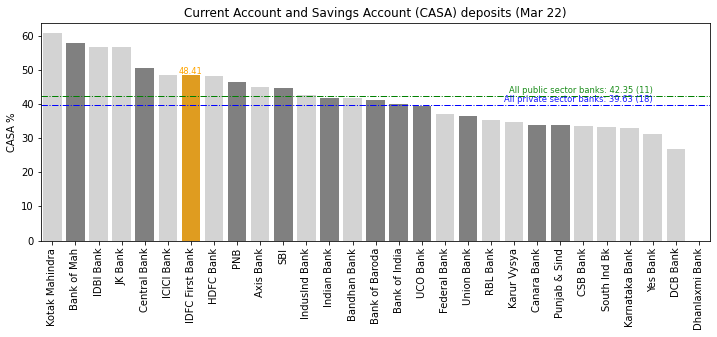

In [44]:
#### CASA %
sheet_name = ['consolidated-ratios', 'ratios']
attributes = ['CASA (%)']
missing, df = extract_info(sheet_name, attributes, 3)
print(f'missing: {len(missing)}')
df['aggregate'] = df.sum(axis= 1)
df['recent'] = df[MOST_RECENT_COL_NAME]
df.dropna(axis = 0, thresh  = 3, inplace = True)
df.dropna(subset = ['recent'], inplace = True)
df.dropna(how = 'all', axis = 1, inplace = True)
df.reset_index(inplace = True)
df.rename(columns = {'level_0' : 'name'}, inplace = True)
df['name'] = df['name'].str.replace('.xlsx', '')
df = append_group(df)

# Plot
### DEPOSITS
df.sort_values(by = 'recent', ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = 'recent', palette = clrs)
plt.xticks(rotation = 90)
plt.title(f'Current Account and Savings Account (CASA) deposits ({MOST_RECENT_COL_NAME})')
plt.ylabel('CASA %')
plt.xlabel('')

# show the company's value
index, value = df[df['name'] == FIRM].index.values[0], df[df['name'] == FIRM]['recent'].values[0]
plt.text(index, value + 0.5, f'{value:.2f}', 
         horizontalalignment='center', size='small', color='orange')

# average CASA % among private sector banks
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight['recent'].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(26, highlight + 1, f'All private sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='blue', alpha = 0.90)

# average CASA % among private sector banks
highlight = df[df['group'] == 'public']
size = highlight.shape[0]
highlight = highlight['recent'].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'green')
plt.text(26, highlight + 1, f'All public sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='green', alpha = 0.90)

plt.show()

### COST TO INCOME RATIO
Book measure of cost to income ratio is different from IDFC First Bank and the industry itself may follow the same or otherwise. I will use both the meaures for reporting.

In [45]:
sheet_name = ['consolidated-profit-loss', 'profit-loss']
attributes = ['Interest / Discount on Advances / Bills',
                'Income from Investments',
                'Interest on Balance with RBI and Other Inter-Bank funds',
                'Others',
                'Total Interest Earned',
                'Other Income',
                'Total Income',
                'Interest Expended',
                'Payments to and Provisions for Employees',
                'Operating Expenses (excludes Employee Cost & Depreciation)',
                'Total Operating Expenses',
                'Total Provisions and Contingencies',
                'Net Profit / Loss for The Year']

missing, df = extract_info(sheet_name, attributes, N)
print(f'missing: {len(missing)}')
df['aggregate'] = df[MOST_RECENT_COL_NAME]#.sum(axis = 1)
df.reset_index(inplace = True)
df.rename(columns = {'level_0' : 'name'}, inplace = True)
df['name'] = df['name'].str.replace('.xlsx', '')
df.head(2)

missing: 0


,name,index,Mar 22,Mar 21,Mar 20,Mar 19,Mar 18,aggregate
0,SBI,Interest / Discount on Advances / Bills,177474.83,176780.19,185494.19,166124.58,144958.59,177474.83
1,SBI,Income from Investments,93477.90,87130.62,74812.87,80243.51,75036.62,93477.90


In [46]:
def get_value(df, name, index, col_name = 'aggregate'):
    return df[(df['name'] == name) & (df['index'] == index)]['aggregate'].values[0]
    
data = []
for name in df['name'].unique():
    interest_on_advances = get_value(df, name, 'Interest / Discount on Advances / Bills')
    interst_on_investments = get_value(df, name, 'Income from Investments')
    interest_on_rbi_other_banks = get_value(df, name, 'Interest on Balance with RBI and Other Inter-Bank funds')
    total_income = get_value(df, name, 'Total Income')
    interest_expended = get_value(df, name, 'Interest Expended')
    operating_income = total_income - interest_expended
    operating_expense = get_value(df, name, 'Total Operating Expenses')
    net_profit = get_value(df, name, 'Net Profit / Loss for The Year')
    cost_to_income_ratio = operating_expense / operating_income

    data.append([name, interest_on_advances, interst_on_investments, 
                 interest_on_rbi_other_banks, total_income, interest_expended, 
                 operating_income, operating_expense, net_profit, cost_to_income_ratio])
    
pl_df = pd.DataFrame(data, 
                  columns = ['name', 'interest_on_advances', 'interest_on_investments', 
                             'interest_on_rbi_other_banks', 'total_income', 'interest_expense', 
                             'operating_income', 'operating_expense', 'net_profit', 'cost_to_income_ratio'])
pl_df.head(2)
        

,name,interest_on_advances,interest_on_investments,interest_on_rbi_other_banks,total_income,interest_expense,operating_income,operating_expense,net_profit,cost_to_income_ratio
0,SBI,177474.83,93477.90,4608.35,406973.09,156194.34,250778.75,174363.43,36356.17,0.695288
1,HDFC Bank,106295.34,25907.06,2630.78,167695.40,58584.33,109111.07,40312.43,38150.90,0.369462


In [47]:
sheet_name = ['consolidated-balance-sheet', 'balance-sheet']
attributes = ['Advances', 'Investments', 'Fixed Assets', 'Total Assets', 
              'Cash and Balances with Reserve Bank of India', 
              'Balances with Banks Money at Call and Short Notice',
              'Total Share Capital', 'Total Reserves and Surplus']

missing, df = extract_info(sheet_name, attributes, N)
print(f'missing: {len(missing)}')
df['aggregate'] = df['Mar 22']#.sum(axis = 1)
df.reset_index(inplace = True)
df.rename(columns = {'level_0' : 'name'}, inplace = True)
df['name'] = df['name'].str.replace('.xlsx', '')
df.head(2)

missing: 0


,name,index,Mar 22,Mar 21,Mar 20,Mar 19,Mar 18,aggregate
0,SBI,Advances,2794076.0,2500598.99,2374311.18,2226853.67,1960118.54,2794076.0
1,SBI,Investments,1776489.9,1595100.27,1228284.28,1119247.77,1183794.24,1776489.9


In [48]:
results = []
for name in df['name'].unique():
    advances = get_value(df, name, 'Advances')
    investments = get_value(df, name, 'Investments')
    with_rbi = get_value(df, name, 'Cash and Balances with Reserve Bank of India')
    with_other_banks = get_value(df, name, 'Balances with Banks Money at Call and Short Notice')
    fixed_assets = get_value(df, name, 'Fixed Assets')
    interest_producing_assets = advances + investments + with_rbi
    total_assets = get_value(df, name, 'Total Assets')
    share_capital = get_value(df, name, 'Total Share Capital')
    retained_earnings = get_value(df, name, 'Total Reserves and Surplus')
    equity_capital = share_capital + retained_earnings
    
    results.append([name, advances, investments, with_rbi, with_other_banks,
                    fixed_assets, interest_producing_assets,
                    total_assets, share_capital, retained_earnings, equity_capital])
    
bs_df = pd.DataFrame(results, columns = ['name', 'advances', 'investments', 
                                         'with_rbi', 'with_other_banks', 'fixed_assets', 'interest_producing_assets',
                                         'total_assets',
                                         'share_capital', 'retained_earnings', 'equity_capital'])
bs_df.head(2)

,name,advances,investments,with_rbi,with_other_banks,fixed_assets,interest_producing_assets,total_assets,share_capital,retained_earnings,equity_capital
0,SBI,2794076.00,1776489.9,258086.43,140818.69,39510.03,4828652.33,5360883.53,892.46,304695.58,305588.04
1,IDBI Bank,145775.33,83475.0,13593.91,13206.56,9987.04,242844.24,302356.26,10752.40,31819.31,42571.71


In [49]:
df = pl_df.merge(bs_df, on = 'name', how = 'left')
df = append_group(df)
df = df.dropna(axis = 0, thresh  = 9)
print(df.shape)
df.head(2)

(28, 21)


,name,interest_on_advances,interest_on_investments,interest_on_rbi_other_banks,total_income,interest_expense,operating_income,operating_expense,net_profit,cost_to_income_ratio,...,investments,with_rbi,with_other_banks,fixed_assets,interest_producing_assets,total_assets,share_capital,retained_earnings,equity_capital,group
0,SBI,177474.83,93477.90,4608.35,406973.09,156194.34,250778.75,174363.43,36356.17,0.695288,...,1776489.90,258086.43,140818.69,39510.03,4828652.33,5360883.53,892.46,304695.58,305588.04,public
1,HDFC Bank,106295.34,25907.06,2630.78,167695.40,58584.33,109111.07,40312.43,38150.90,0.369462,...,449263.86,130030.71,25355.02,6432.07,2000236.85,2122934.30,554.55,246771.62,247326.17,private


In [50]:
# Question 1: Return on advances, investments, and rbi/other banks
df['return_on_advances'] = df['interest_on_advances'] / df['advances']
df['return_on_investments'] = df['interest_on_investments'] / df['investments']
df['return_on_rbi_other_banks'] = df['interest_on_rbi_other_banks'] / (df['with_rbi'] + df['with_other_banks'])
df['roe'] = 100 * df['net_profit'] / df['equity_capital']

In [51]:
## TOTAL ASSETS
df['total_assets'].sum()

20402187.069999997

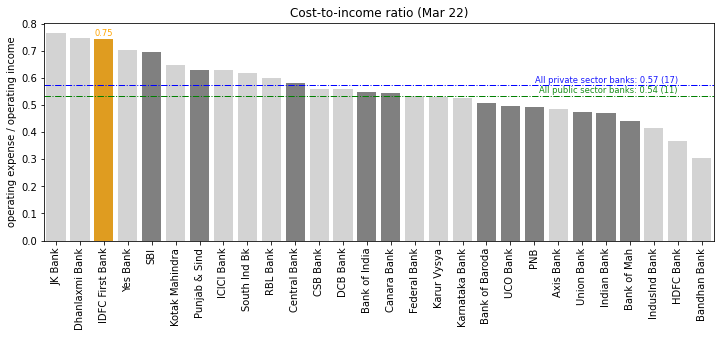

In [52]:
# Plot
### COST TO INCOME
col_name = 'cost_to_income_ratio'
df.sort_values(by = col_name, ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = col_name, palette = clrs)
plt.xticks(rotation = 90)
plt.title(f'Cost-to-income ratio ({MOST_RECENT_COL_NAME})')
plt.ylabel('operating expense / operating income')
plt.xlabel('')

# show the company's value
index, value = df[df['name'] == FIRM].index.values[0], df[df['name'] == FIRM][col_name].values[0]
plt.text(index, value + 0.01, f'{value:.2f}', 
         horizontalalignment='center', size='small', color='orange')

# average CASA % among private sector banks
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight[col_name].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(26, highlight + 0.01, f'All private sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='blue', alpha = 0.90)

# average CASA % among private sector banks
highlight = df[df['group'] == 'public']
size = highlight.shape[0]
highlight = highlight[col_name].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'green')
plt.text(26, highlight + 0.01, f'All public sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='green', alpha = 0.90)

plt.show()

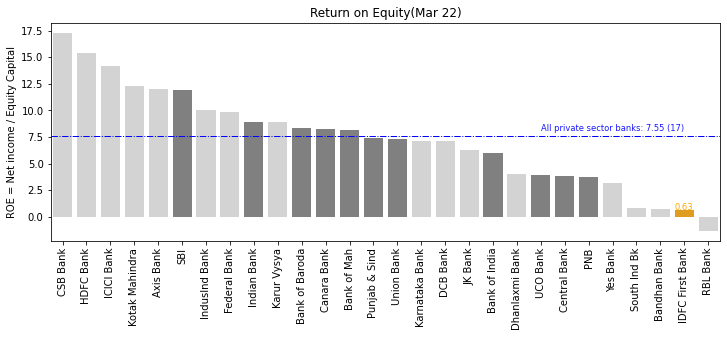

In [53]:
# Plot
### Return on Equity
col_name = 'roe'
df.sort_values(by = col_name, ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = col_name, palette = clrs)
plt.xticks(rotation = 90)
plt.title(f'Return on Equity({MOST_RECENT_COL_NAME})')
plt.ylabel('ROE = Net income / Equity Capital')
plt.xlabel('')

# show the company's value
index, value = df[df['name'] == FIRM].index.values[0], df[df['name'] == FIRM][col_name].values[0]
plt.text(index, value + 0.01, f'{value:.2f}', 
         horizontalalignment='center', size='small', color='orange')

# average CASA % among private sector banks
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight[col_name].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(26, highlight + 0.5, f'All private sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='blue', alpha = 0.90)

plt.show()

In [54]:
## TRAILING 12 MONTHS
sheet_name = ['consolidated-quarterly-results', 'quarterly-results']
attributes = ['Net Profit/(Loss) For the Period']

missing, q_df = extract_info(sheet_name, attributes, n=4)
print(f'missing: {len(missing)}')
q_df['ttm_net_profit'] = q_df.sum(axis = 1)
q_df.reset_index(inplace = True)
q_df.rename(columns = {'level_0' : 'name',}, inplace = True)
q_df['name'] = q_df['name'].str.replace('.xlsx', '')
q_df = q_df[['name', 'ttm_net_profit']]

df = df.merge(q_df, on = 'name', how = 'left')

missing: 0


In [55]:
# THIS IS INCORRECT BECAUSE EQUITY CAPITAL IS FROM Mar 22 while the net_profit is sum of 
# previous 4 quarters
df['ttm_roe'] = df['ttm_net_profit'] / df['equity_capital']

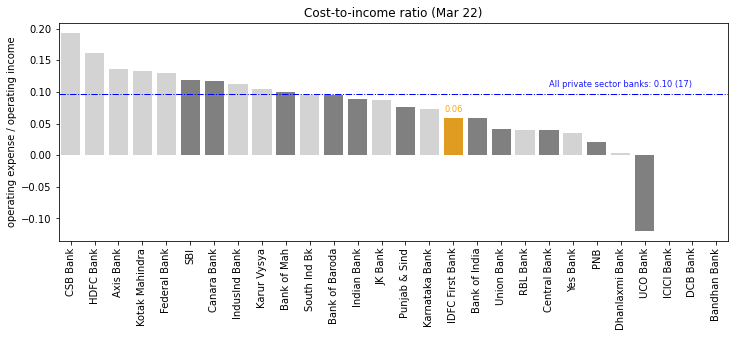

In [56]:
# Plot
### Return on Equity
col_name = 'ttm_roe'
df.sort_values(by = col_name, ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = col_name, palette = clrs)
plt.xticks(rotation = 90)
plt.title(f'Cost-to-income ratio ({MOST_RECENT_COL_NAME})')
plt.ylabel('operating expense / operating income')
plt.xlabel('')

# show the company's value
index, value = df[df['name'] == FIRM].index.values[0], df[df['name'] == FIRM][col_name].values[0]
plt.text(index, value + 0.01, f'{value:.2f}', 
         horizontalalignment='center', size='small', color='orange')

# average CASA % among private sector banks
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight[col_name].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(26, highlight + 0.01, f'All private sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='blue', alpha = 0.90)

plt.show()

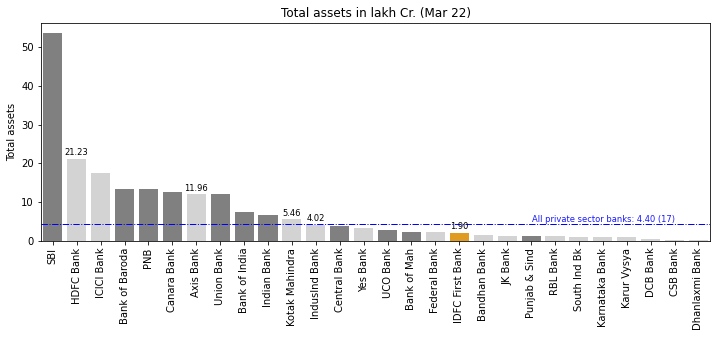

In [57]:
# Plot
### TOTAL ASSETS
df['total_assets_in_lakh_cr'] = df['total_assets'] / 1e5
col_name = 'total_assets_in_lakh_cr'
df.sort_values(by = col_name, ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = col_name, palette = clrs)
plt.xticks(rotation = 90)
plt.title(f'Total assets in lakh Cr. ({MOST_RECENT_COL_NAME})')
plt.ylabel('Total assets')
plt.xlabel('')

# show the company's value
firms = ['IndusInd Bank', 'Axis Bank', 'HDFC Bank', 'Kotak Mahindra', FIRM]
for firm in firms:
    index, value = df[df['name'] == firm].index.values[0], df[df['name'] == firm][col_name].values[0]
    plt.text(index, value + 1, f'{value:.2f}', 
            horizontalalignment='center', size='small', color='black')

# average CASA % among private sector banks
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight[col_name].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(26, highlight + 0.5, f'All private sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='blue', alpha = 0.90)

plt.show()

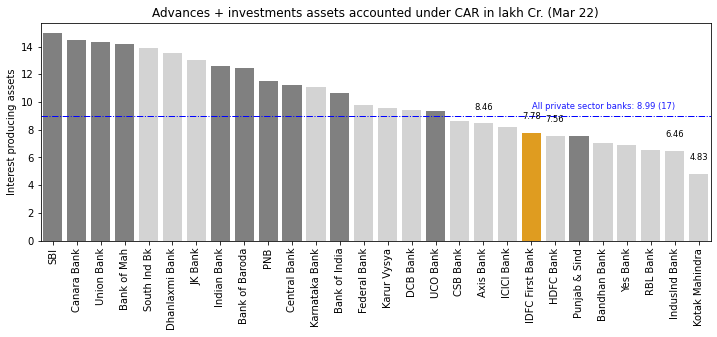

In [60]:
# Plot
### TOTAL ASSETS
df['int_assets'] = df['advances'] + df['investments']
df['adj_car'] = df['int_assets'] / df['equity_capital']
col_name = 'adj_car'
df.sort_values(by = col_name, ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = col_name, palette = clrs)
plt.xticks(rotation = 90)
plt.title(f'Advances + investments assets accounted under CAR in lakh Cr. ({MOST_RECENT_COL_NAME})')
plt.ylabel('Interest producing assets')
plt.xlabel('')

# show the company's value
firms = ['IndusInd Bank', 'Axis Bank', 'HDFC Bank', 'Kotak Mahindra', FIRM]
for firm in firms:
    index, value = df[df['name'] == firm].index.values[0], df[df['name'] == firm][col_name].values[0]
    plt.text(index, value + 1, f'{value:.2f}', 
            horizontalalignment='center', size='small', color='black')

# average CASA % among private sector banks
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight[col_name].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(26, highlight + 0.5, f'All private sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='blue', alpha = 0.90)

plt.show()

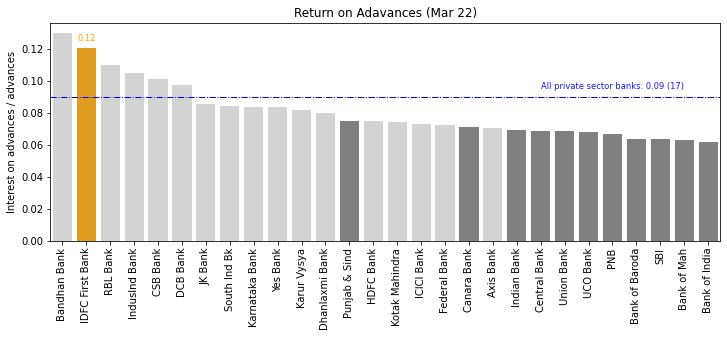

In [24]:
# Plot
### Return on Equity
col_name = 'return_on_advances'
df.sort_values(by = col_name, ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = col_name, palette = clrs)
plt.xticks(rotation = 90)
plt.title(f'Return on Adavances ({MOST_RECENT_COL_NAME})')
plt.ylabel('Interest on advances / advances')
plt.xlabel('')

# show the company's value
index, value = df[df['name'] == FIRM].index.values[0], df[df['name'] == FIRM][col_name].values[0]
plt.text(index, value + 0.005, f'{value:.2f}', 
         horizontalalignment='center', size='small', color='orange')

# average CASA % among private sector banks
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight[col_name].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(26, highlight + 0.005, f'All private sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='blue', alpha = 0.90)

plt.show()

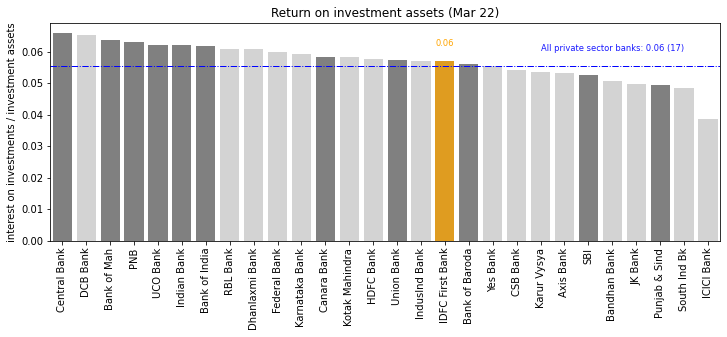

In [25]:
# Plot
### Return on Equity
col_name = 'return_on_investments'
df.sort_values(by = col_name, ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = col_name, palette = clrs)
plt.xticks(rotation = 90)
plt.title(f'Return on investment assets ({MOST_RECENT_COL_NAME})')
plt.ylabel('interest on investments / investment assets')
plt.xlabel('')

# show the company's value
index, value = df[df['name'] == FIRM].index.values[0], df[df['name'] == FIRM][col_name].values[0]
plt.text(index, value + 0.005, f'{value:.2f}', 
         horizontalalignment='center', size='small', color='orange')

# average CASA % among private sector banks
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight[col_name].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(26, highlight + 0.005, f'All private sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='blue', alpha = 0.90)

plt.show()

In [26]:
df['advances_to_total_assets'] = df['advances'] / df['interest_producing_assets']
df['investments_to_total_assets'] = df['investments'] / df['interest_producing_assets']
df['with_rbi_to_total_assets'] = df['with_rbi'] / df['interest_producing_assets']
df['non_interest_producing_assets'] = (df['total_assets'] - df['fixed_assets'] - df['interest_producing_assets'])
df['non_interest_producing_assets_to_total_assets'] = df['non_interest_producing_assets'] / df['total_assets']
df['interest_producing_assets_to_total_assets'] = df['interest_producing_assets'] / df['total_assets']

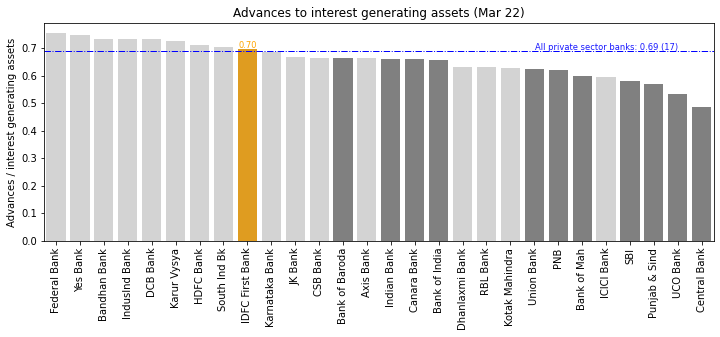

In [27]:
# Plot
### Return on Equity
col_name = 'advances_to_total_assets'
df.sort_values(by = col_name, ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = col_name, palette = clrs)
plt.xticks(rotation = 90)
plt.title(f'Advances to interest generating assets ({MOST_RECENT_COL_NAME})')
plt.ylabel('Advances / interest generating assets')
plt.xlabel('')

# show the company's value
index, value = df[df['name'] == FIRM].index.values[0], df[df['name'] == FIRM][col_name].values[0]
plt.text(index, value + 0.005, f'{value:.2f}', 
         horizontalalignment='center', size='small', color='orange')

# average CASA % among private sector banks
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight[col_name].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(26, highlight + 0.005, f'All private sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='blue', alpha = 0.90)

plt.show()

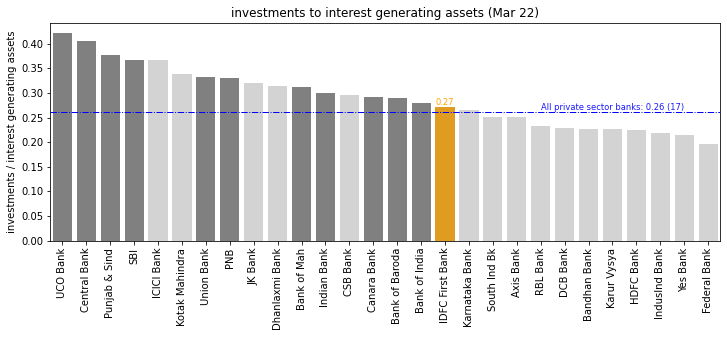

In [28]:
# Plot
### Return on Equity
col_name = 'investments_to_total_assets'
df.sort_values(by = col_name, ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = col_name, palette = clrs)
plt.xticks(rotation = 90)
plt.title(f'investments to interest generating assets ({MOST_RECENT_COL_NAME})')
plt.ylabel('investments / interest generating assets')
plt.xlabel('')

# show the company's value
index, value = df[df['name'] == FIRM].index.values[0], df[df['name'] == FIRM][col_name].values[0]
plt.text(index, value + 0.005, f'{value:.2f}', 
         horizontalalignment='center', size='small', color='orange')

# average CASA % among private sector banks
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight[col_name].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(26, highlight + 0.005, f'All private sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='blue', alpha = 0.90)

plt.show()

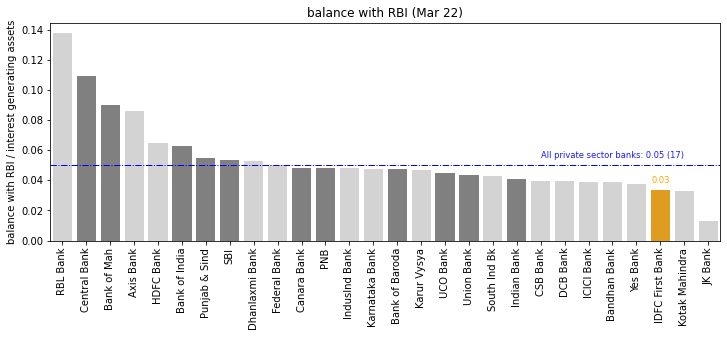

In [29]:
# Plot
### Return on Equity
col_name = 'with_rbi_to_total_assets'
df.sort_values(by = col_name, ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = col_name, palette = clrs)
plt.xticks(rotation = 90)
plt.title(f'balance with RBI ({MOST_RECENT_COL_NAME})')
plt.ylabel('balance with RBI / interest generating assets')
plt.xlabel('')

# show the company's value
index, value = df[df['name'] == FIRM].index.values[0], df[df['name'] == FIRM][col_name].values[0]
plt.text(index, value + 0.005, f'{value:.2f}', 
         horizontalalignment='center', size='small', color='orange')

# average CASA % among private sector banks
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight[col_name].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(26, highlight + 0.005, f'All private sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='blue', alpha = 0.90)

plt.show()

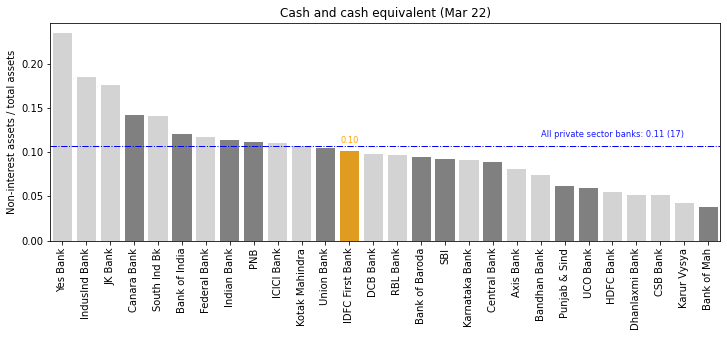

In [30]:
# Plot
### Return on Equity
col_name = 'non_interest_producing_assets_to_total_assets'
df.sort_values(by = col_name, ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = col_name, palette = clrs)
plt.xticks(rotation = 90)
plt.title(f'Cash and cash equivalent ({MOST_RECENT_COL_NAME})')
plt.ylabel('Non-interest assets / total assets')
plt.xlabel('')

# show the company's value
index, value = df[df['name'] == FIRM].index.values[0], df[df['name'] == FIRM][col_name].values[0]
plt.text(index, value + 0.01, f'{value:.2f}', 
         horizontalalignment='center', size='small', color='orange')

# average CASA % among private sector banks
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight[col_name].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(26, highlight + 0.01, f'All private sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='blue', alpha = 0.90)

plt.show()

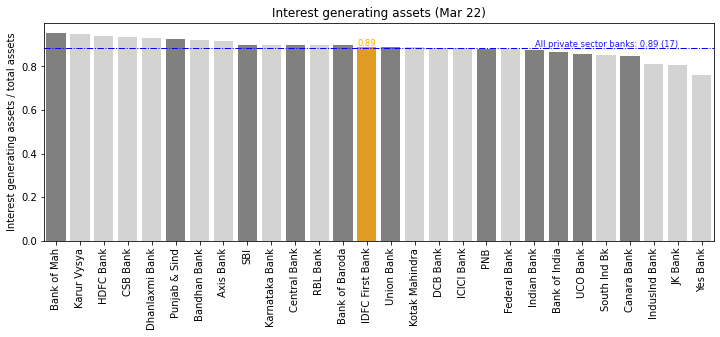

In [31]:
# Plot
### Return on Equity
col_name = 'interest_producing_assets_to_total_assets'
df.sort_values(by = col_name, ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = col_name, palette = clrs)
plt.xticks(rotation = 90)
plt.title(f'Interest generating assets ({MOST_RECENT_COL_NAME})')
plt.ylabel('Interest generating assets / total assets')
plt.xlabel('')

# show the company's value
index, value = df[df['name'] == FIRM].index.values[0], df[df['name'] == FIRM][col_name].values[0]
plt.text(index, value + 0.005, f'{value:.2f}', 
         horizontalalignment='center', size='small', color='orange')

# average CASA % among private sector banks
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight[col_name].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(26, highlight + 0.005, f'All private sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='blue', alpha = 0.90)

plt.show()

missing: 1


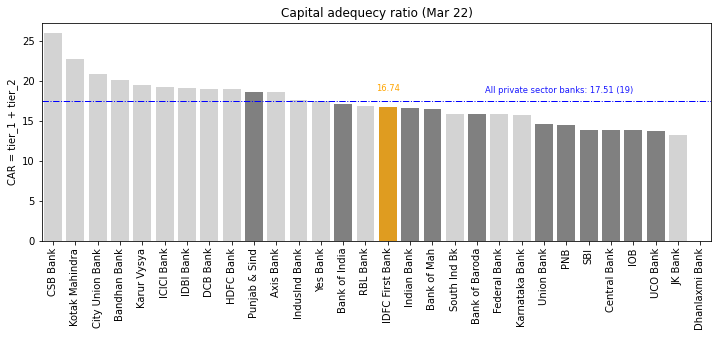

In [32]:
# CAPITAL ADEQUACY RATIO
sheet_name = ['balance-sheet', 'consolidated-balance-sheet']
attributes = ['Tier 1 (%)', 'Tier 2 (%)']

missing, df = extract_info(sheet_name, attributes, n=4)
print(f'missing: {len(missing)}')
df.reset_index(inplace = True)
df.rename(columns = {'level_0' : 'name',}, inplace = True)
df['name'] = df['name'].str.replace('.xlsx', '')
df['aggregate'] = df[MOST_RECENT_COL_NAME]

# AGGREGATE
results = []
for name in df['name'].unique():
    tier_1 = get_value(df, name, 'Tier 1 (%)')
    tier_2 = get_value(df, name, 'Tier 2 (%)')
    cap_adeq_ratio = tier_1 + tier_2
    results.append([name, tier_1, tier_2, cap_adeq_ratio])
    
df = pd.DataFrame(results, columns = ['name', 'tier_1', 'tier_2', 'cap_adeq_ratio'] )
df = append_group(df)

# PLOT
col_name = 'cap_adeq_ratio'
df.sort_values(by = col_name, ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)
plt.figure(figsize = (12, 4))
clrs = [PRIVATE_DEFAULT_COLOR if group == 'private' else PUBLIC_DEFAULT_COLOR for group in df['group']]
clrs = [HIGHLIGHT if f == FIRM else clrs[i] for i, f in enumerate(df['name'])]
sns.barplot(data = df, x = 'name', y = col_name, palette = clrs)
plt.xticks(rotation = 90)
plt.title(f'Capital adequecy ratio ({MOST_RECENT_COL_NAME})')
plt.ylabel('CAR = tier_1 + tier_2')
plt.xlabel('')

# show the company's value
index, value = df[df['name'] == FIRM].index.values[0], df[df['name'] == FIRM][col_name].values[0]
plt.text(index, value + 2, f'{value:.2f}', 
         horizontalalignment='center', size='small', color='orange')

# average CASA % among private sector banks
highlight = df[df['group'] == 'private']
size = highlight.shape[0]
highlight = highlight[col_name].mean()
plt.axhline(y = highlight, ls = '-.', lw = 1, color = 'blue')
plt.text(26, highlight + 1, f'All private sector banks: {highlight:.2f} ({int(size)})', 
         horizontalalignment='right', size='small', color='blue', alpha = 0.90)

plt.show()

In [33]:
df.to_clipboard()